#We provide Python code for the respective functions used in peptide drug screening, based on the work of Wei T, Ma J, Cui X, Lin J, Zheng Z, Cheng L, Cui T, Lin X, Zhu J, Ran X, Hong X, Johnston L, Yu Z, Chen H. AI-Driven De Novo Design of Ultra Long-Acting GLP-1 Receptor Agonists. Adv Sci (Weinh). 2025

# motifRMSD

In [18]:
import os
import numpy as np
import re
import warnings
import argparse
import logging
import time
import shutil
import typing as T
from typing import List
from pathlib import Path

from Bio.PDB import *
from Bio.SVDSuperimposer import SVDSuperimposer
from Bio.PDB.PDBParser import PDBConstructionWarning as BiopythonWarning

def motifRMSD(
    ref_pdb, des_pdb, ref_motif ,
    des_motif, option="CA"):
    
    paser = PDBParser()
    structure_ref = paser.get_structure("ref", ref_pdb)
    structure_des = paser.get_structure("des", des_pdb)
    if option == "CA":
        ref_coord = []
        des_coord = []
        lstd = [] 
        for  i in structure_ref[0].get_chains():
            lstd.append(i)
        for chain in ref_motif.keys():
            #print(chain)
            #model_ref = structure_ref[0]
            
            for id in ref_motif[chain]:
                 
                res_ref = lstd[-1][id]
                ca_ref = res_ref["CA"]
                ref_coord.append(ca_ref.get_coord())
        lstd = [] 
        for  i in structure_des[0].get_chains():
            lstd.append(i)
        #print(len(lstd[1]))
        for chain in des_motif.keys():
            
            model_des = structure_des[0]
            for id in des_motif[chain]:
            
                
                res_des = lstd[-1][id]
                ca_des = res_des["CA"]
                
                des_coord.append(ca_des.get_coord())
        ref_coord = np.array(ref_coord)
        des_coord = np.array(des_coord)
        sup = SVDSuperimposer()
        sup.set(des_coord, ref_coord)
        sup.run()
        motif_rmsd = sup.get_rms()
        return motif_rmsd

def get_all_filenames(folder_path):
    files = os.listdir(folder_path)
    return files
folder_path = "/dssg/home/acct-clsyzs/clsyzs/C1/abl_colab_re/"
all_filenames = get_all_filenames(folder_path)
if '.ipynb_checkpoints' in all_filenames:
    i = all_filenames.index('.ipynb_checkpoints')
    all_filenames.pop(i)

lst_rmsd = {}

motif_set= {"P":[i+1 for i in range(33)]}
motif_set_query = {"B":[i+1 for i in range(33)]}
for i in all_filenames:#sample_lst_1401_50.keys():
    

    lst_rmsd[i] = motifRMSD("./7y35-complex.pdb",folder_path+i+"/7Y35_1_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb",motif_set,motif_set_query)

    


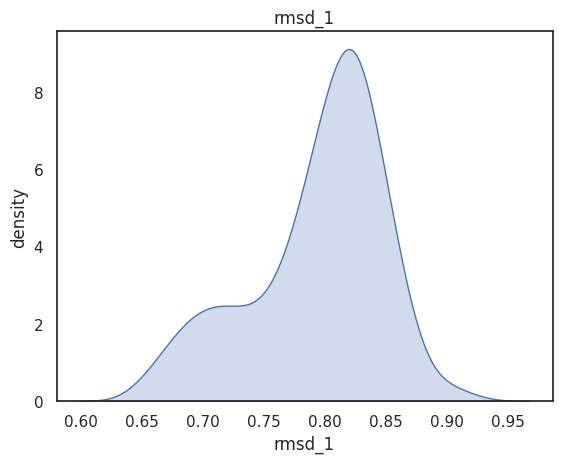

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype

# 用于数据可视化：
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)


sns.kdeplot(lst_rmsd.values(), shade=True, label="rmsd")
# 设置图表标题和坐标轴标签
plt.title("rmsd_1")
plt.xlabel("rmsd_1")
plt.ylabel("density")

# 显示图形
plt.show()

In [81]:
fliter_rmsd = []
for i in fliter_plddt_pae:
    if lst_rmsd[i] <0.8:
        fliter_rmsd.append(i)

# the cleavage sites filtered out

In [1]:
with open("./project_abl_re.txt", "r", encoding="utf-8") as file:
        lines = file.readlines()

In [2]:
lst_seq = {}
for i in lines:
    name, seq = i.split()
    lst_seq[name] = seq

In [4]:
sites = ["EF","WL","DV","SY","YL","FI"]
num = {"EF":0,"WL":0,"DV":0,"SY":0,"YL":0,"FI":0}
index_lst_site = []
for i in lst_seq:
    os = True
    for site in sites:
        if site in lst_seq[i]:
            os = False
            continue
    if os == True:
        index_lst_site.append(i)

In [5]:
len(index_lst_site)

269

# non_polar_polar (hydrophobicity)

In [6]:
import sys
import os
import logging
import time
import re
import argparse
import shutil
import typing as T
from typing import List, Tuple
from pathlib import Path

import torch
import math
import mdtraj as md



def load_pdb(pdb_file: Path) -> tuple[md.Topology, md.Trajectory]:
    top = md.load(pdb_file).topology
    t = md.load(pdb_file, top)
    return top, t


def calculate_backbone_neighbors(pdb_file: Path) -> torch.Tensor:
    top, t = load_pdb(pdb_file)
    CBs_index = top.select("backbone and name C")
    CBs_coords = t.xyz[
        0,
        CBs_index,
    ]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    CBs_coords = torch.from_numpy(CBs_coords).to(device)
    CBs_dis = torch.norm(CBs_coords[:, None] - CBs_coords, dim=2, p=2)
    return CBs_dis


def polar_nopolar(pdb_file: Path) -> tuple[torch.Tensor, torch.Tensor]:
    top, t = load_pdb(pdb_file)
    residues = [str(residue) for residue in t.topology.residues]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    non_polar = torch.zeros(len(residues))
    non_polar = non_polar.to(device)
    polar = torch.zeros(len(residues))
    polar = polar.to(device)
    for i in range(len(residues)):
        if residues[i][:3] in ["ILE", "LEU", "MET", "TRP", "PHE", "VAL"]:
            non_polar[i] = 1
        if residues[i][:3] in ["SER", "THR", "TYR", "ASN", "GLN"]:
            polar[i] = 1
    return non_polar, polar


def angle(pdb_file: Path) -> torch.Tensor:
    top, t = load_pdb(pdb_file)
    CBs_index = top.select("backbone and name C")
    CBs_coords = t.xyz[
        0,
        CBs_index,
    ]
    CAs_index = top.select("backbone and name CA")
    CAs_coords = t.xyz[
        0,
        CAs_index,
    ]
    CAs_CBs_coords = CBs_coords - CAs_coords
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    CAs_CBs_coords = torch.from_numpy(CAs_CBs_coords).to(device)
    norm = torch.sqrt(torch.sum(torch.mul(CAs_CBs_coords, CAs_CBs_coords), dim=1))
    phi_ij = torch.zeros(
        (CAs_CBs_coords.shape[0], CAs_CBs_coords.shape[0])
    )  # 求得夹角（弧度制）：
    phi_ij = phi_ij.to(device)
    for i in range(CAs_CBs_coords.shape[0]):
        for j in range(CAs_CBs_coords.shape[0]):
            if j > i:
                cos = torch.sum(
                    torch.mul(
                        CAs_CBs_coords[
                            i,
                        ],
                        CAs_CBs_coords[
                            j,
                        ],
                    )
                ) / (norm[i] * norm[j])
                if cos > 1:
                    cos = torch.tensor(([1]))
                if cos < -1:
                    cos = torch.tensor(([-1]))
                phi_ij[i, j] = torch.arccos(cos)
                phi_ij[j, i] = phi_ij[i, j]
    return phi_ij


def non_polar_polar(pdb_file: Path) -> float:
    CBs_dis = calculate_backbone_neighbors(pdb_file)
    non_polar, polar = polar_nopolar(pdb_file)
    phi_ij = angle(pdb_file)
    #print(non_polar.shape)
    m = 1
    a = 0.5
    b = 2
    distance = 1 / (1 + torch.exp(CBs_dis - m))
    degree = ((torch.cos(math.pi - phi_ij) + a) / (1 + a)) ** b
    distance_degree = torch.mul(distance, degree)
    n_i = torch.sum(
        distance_degree - torch.diag_embed(torch.diag(distance_degree)), dim=1
    )
    #print(n_i.shape)
    polar_score = torch.sum(
        non_polar * (1 - torch.sigmoid(n_i - torch.median(n_i)))
    ) / torch.sum(1 - torch.sigmoid(n_i - torch.median(n_i)))
    return polar_score


/dssg/home/acct-clsyzs/clsyzs/.conda/envs/se3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
sps_lst = {}
for i in index_lst_site:
    sps_lst[i] = non_polar_polar("./p1_single_nomsa_1/"+i+".pdb")

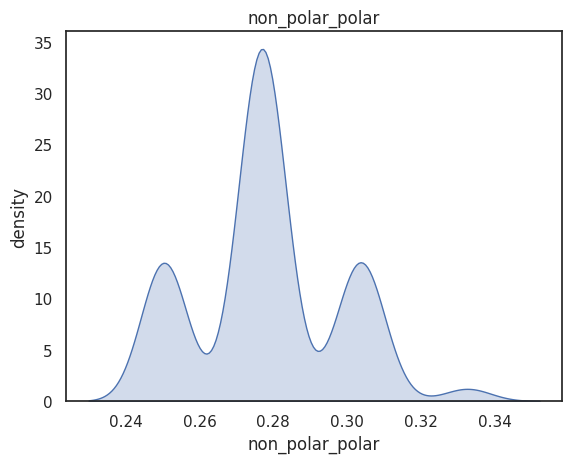

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

sns.kdeplot(torch.tensor(list(sps_lst.values())).cpu(), shade=True, label="non_polar_polar")

# 设置图表标题和坐标轴标签
plt.title("non_polar_polar")
plt.xlabel("non_polar_polar")
plt.ylabel("density")

# 显示图形
plt.show()


In [9]:
sps_ed_lst = []
for i in sps_lst:
    if sps_lst[i]< 0.30:
        sps_ed_lst.append(i)
print(len(sps_ed_lst))

221


# SAP

In [10]:
import sys
import os
import logging
import time
import re
import argparse
import shutil
import typing as T
from typing import List
from pathlib import Path

from pyrosetta import *
from pyrosetta.rosetta import *

pyrosetta.init()

"""
Calculate SAP score of PDBs, and filter them out using specified threshold.

Usage:
[Required]
"-d", "--design_path": Folder containing the PDBs of which you want to compute SAP score.
[Options]
"-r", "--reference_pdb": The PDB you want to compare calculated SAP score with.
"--sap": The SAP filtering threshold. PDBs with SAP score lower than this value will be kept, otherwise would be filtered out.
"--root-path": Root path of operation. Default = My own SAP filtering folder.  
"""

PathLike = T.Union[str, Path]


def calculation_sap(pdb):
    pose = pyrosetta.pose_from_file(pdb)
    calc_sap = pyrosetta.rosetta.core.pack.guidance_scoreterms.sap.SapScoreMetric()
    sap = calc_sap.calculate(pose)
    return sap

PyRosetta-4 2023 [Rosetta PyRosetta4.Release.python39.linux 2024.01+release.00b79147e63be743438188f93a3f069ca75106d6 2023-12-25T16:35:48] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python39.linux r366 2024.01+release.00b7914 00b79147e63be743438188f93a3f069ca75106d6 http://www.pyrosetta.org 2023-12-25T16:35:48
core.init: command: PyRosetta -ex1 -ex2aro -database /dssg/home/acct-clsyzs/clsyzs/.local/lib/python3.9/site-packages/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-1282173999 seed_offset=0 real_seed=-1282173999
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=-1282173999 RG_type=mt19937


In [11]:
sap_lst = {}
for i in sps_ed_lst:
    sap_lst[i] = calculation_sap("./p1_single_nomsa_1/"+i+".pdb")#42.44648742675781

core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 985 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 2.83771 seconds.
core.import_pose.import_pose: File '/dssg/home/acct-clsyzs/clsyzs/C1/abl_project/p1_single_nomsa_1/0.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue ALA:CtermProteinFull 34
basic.io.database: Database file opened: scoring/score_functions/sap_sasa_calib.dat
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
core.import_pose.import_pose: File '/dssg/home/acct-clsyzs/clsyzs/C1/abl_project/p1_single_nomsa_1/1.pdb' automat

/tmp/ipykernel_3473245/1541139629.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(list(sap_lst.values()), shade=True, label="SAP")


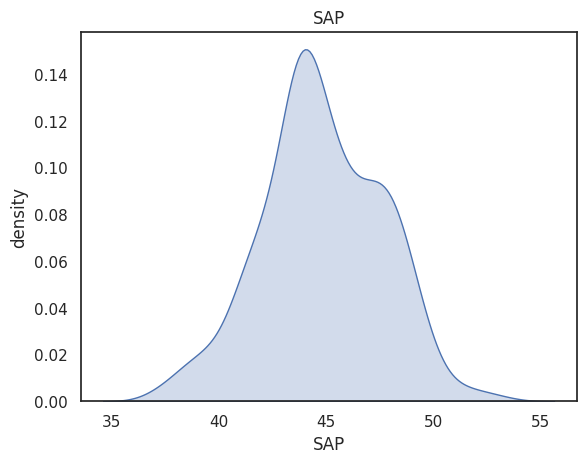

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype

# 用于数据可视化：
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

sns.kdeplot(list(sap_lst.values()), shade=True, label="SAP")

# 设置图表标题和坐标轴标签
plt.title("SAP")
plt.xlabel("SAP")
plt.ylabel("density")

# 显示图形
plt.show()


In [17]:
sap_ed_lst = []
for i in sap_lst:
    if sap_lst[i]< 44:
        sap_ed_lst.append(i)
print(len(sap_ed_lst))

93


In [96]:
def calculate_difference(s, lst):
    result = []
    for item in lst:
        diff = sum(1 for a, b in zip(s, item) if a == b)
        result.append(diff/34)
    return result

s = "AVSEHQLLHDKGKSIQDLRRRELLEKLLAKLHTA"


result = calculate_difference(s, seq.values())
print(result)

[0.6764705882352942, 0.6470588235294118, 0.6470588235294118, 0.6470588235294118, 0.7058823529411765, 0.6470588235294118, 0.6470588235294118, 0.7058823529411765, 0.6764705882352942, 0.6470588235294118, 0.6764705882352942, 0.6470588235294118, 0.6764705882352942, 0.6470588235294118, 0.7058823529411765, 0.6764705882352942, 0.7058823529411765, 0.7058823529411765, 0.6764705882352942, 0.6470588235294118, 0.7058823529411765, 0.7058823529411765, 0.6764705882352942, 0.6470588235294118, 0.7058823529411765, 0.6764705882352942, 0.6764705882352942, 0.6470588235294118, 0.6470588235294118, 0.6176470588235294, 0.6470588235294118, 0.7058823529411765, 0.6176470588235294, 0.6764705882352942, 0.6470588235294118, 0.6764705882352942, 0.6176470588235294, 0.6764705882352942, 0.6470588235294118, 0.6764705882352942, 0.6764705882352942, 0.6764705882352942, 0.7058823529411765, 0.6764705882352942, 0.6176470588235294, 0.7058823529411765, 0.7058823529411765, 0.6764705882352942, 0.6764705882352942, 0.6176470588235294,

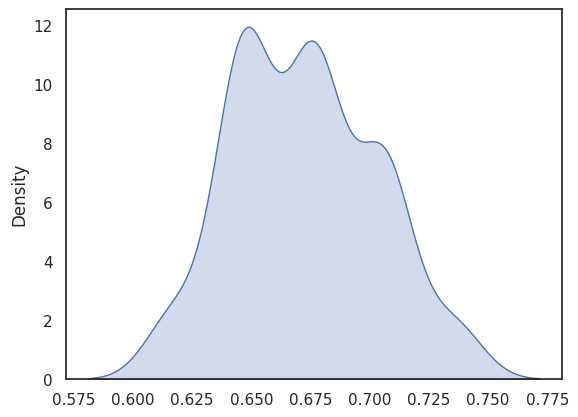

In [99]:
 
# 用于数据可视化：
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

sns.kdeplot(result, shade=True, label="recovery")

# 设置图表标题和坐标轴标签


# 显示图形
plt.show()



# TM-score

In [101]:
pip install tmtools

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 104.8 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [113]:
import os
import argparse
import numpy as np
import subprocess
import argparse
import typing as T
from pathlib import Path
from typing import *
from time import time
from multiprocessing import Value
from genericpath import isfile

import MDAnalysis as mda
from MDAnalysis.analysis import rms
from tmtools import tm_align
from tmtools.io import get_residue_data, get_structure

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



class StructuralSimilarity:
    def __init__(self) -> None:
        pass

    @staticmethod
    def parse_tmalign_output(out):
        rmsd = None
        tm_score = None

        for line in out.split("\n"):
            if "RMSD" in line:
                try:
                    rmsd = float(line.split("=")[1].strip().split(",")[0])
                except ValueError:
                    pass
            elif "TM-score" in line:
                try:
                    tm_score = float(line.split("=")[1].strip().split("(if")[0])
                except ValueError:
                    pass

        return rmsd, tm_score

    def CA_rmsd(self, esm: Path, af2: Path) -> float:
        u1 = mda.Universe(esm)
        u2 = mda.Universe(af2)
        rmsd = rms.rmsd(
            u1.select_atoms("backbone").positions,
            u2.select_atoms("backbone").positions,
            center=True,
            superposition=True,
        )
        return rmsd

    @staticmethod
    def tmtools_calculate(pdb1: Path, pdb2: Path) -> float:
        s1, s2 = (get_structure(pdb1), get_structure(pdb2))
        k1, k2 = s1.get_chains(),s2.get_chains()
        chain1, chain2 = (next(k1), next(k2))
        
        
        c1, seq1 = get_residue_data(chain1)
        c2, seq2 = get_residue_data(chain2)
        
        chain1, chain2 = (next(k1), next(k2))
        
        c11, seq11 = get_residue_data(chain1)
        c21, seq21 = get_residue_data(chain2)
        
        seq1 = seq1 +seq11
        seq2 = seq2+seq21
        c1 = np.concatenate((c1, c11))
        c2 = np.concatenate((c2, c21))
        
        res = tm_align(c1, c2, seq1, seq2)
        tm_score = round((res.tm_norm_chain1 + res.tm_norm_chain2) / 2, 3)
    
        return tm_score
    
    def tmtools_calculate1(pdb1: Path, pdb2: Path) -> float:
        s1, s2 = (get_structure(pdb1), get_structure(pdb2))
        chain1, chain2 = (next(s1.get_chains()), next(s2.get_chains()))
        
       
         
        c1, seq1 = get_residue_data(chain1)
        c2, seq2 = get_residue_data(chain2)
        
        res = tm_align(c1, c2, seq1, seq2)
        tm_score = round((res.tm_norm_chain1 + res.tm_norm_chain2) / 2, 3)
        
        return tm_score

    @staticmethod
    def tmalign_wrapper(template, temp_pdbfile, force_alignment=None):
        try:
            if force_alignment == None:
                p = subprocess.Popen(
                    f'TMalign {template} {temp_pdbfile} | grep -E "RMSD|TM-score=" ',
                    stdout=subprocess.PIPE,
                    shell=True,
                )
            else:
                p = subprocess.Popen(
                    f'TMalign {template} {temp_pdbfile} -I {force_alignment} | grep -E "RMSD|TM-score=" ',
                    stdout=subprocess.PIPE,
                    shell=True,
                )
            output, __ = p.communicate()
            output = output.decode("utf-8")
            tm_rmsd = float(str(output)[:-3].split("RMSD=")[-1].split(",")[0])
            tm_score = float(str(output)[:-3].split("TM-score=")[-1].split("(if")[0])
        except ValueError as e:
            cmd = ["TMalign", template, temp_pdbfile]
            print("1")
            result = subprocess.run(cmd, capture_output=True, text=True, check=True)
            output = result.stdout
            print(f"output: {result.stderr}")
            tm_rmsd, tm_score = StructuralSimilarity.parse_tmalign_output(output)
        return tm_rmsd, tm_score

    def tm_score(
        self, ref: Path, pdb: Path, mode=1
    ) -> Union[float, List[Tuple[str, float]]]:
        PathLike = T.Union[str, Path]
        score = None
         
        if mode == 1:
             
            if os.path.isfile(ref) and os.path.isfile(pdb):
                score = StructuralSimilarity.tmtools_calculate(ref, pdb)
                #print(1)
            elif os.path.isfile(ref) and os.path.isdir(pdb):
                #print(1)
                score = []
                for file in os.listdir(pdb):
                    if file.endswith(".pdb"):
                        pdb_name = file#.stem
                        tmscore = StructuralSimilarity.tmtools_calculate(ref, pdb+file)
                        score.append((pdb_name, tmscore))
        elif mode == 2:
            if os.path.isfile(ref) and os.path.isfile(pdb):
                score = StructuralSimilarity.tmalign_wrapper(ref, pdb)[1]
            elif os.path.isfile(ref) and os.path.isdir(pdb):
                score = []
                for file in os.listdir(pdb):
                    if file.endswith(".pdb"):
                        ref_path = ref.absolute()
                        pdb_path = file.absolute()
                        pdb_name = pdb_path.stem
                        _, tmscore = tmalign_wrapper(ref_path, pdb_path)
                        score.append((pdb_name, tmscore))
        
        return score


In [114]:
tm_score = {}
for i in sap_ed_lst:
    tm_score[i] = StructuralSimilarity().tm_score("/dssg/home/acct-clsyzs/clsyzs/C1/7y35_1.pdb","/dssg/home/acct-clsyzs/clsyzs/C1/abl_project/complex/"+i+".pdb")

# Simplified net charge calculation function

In [ ]:
def charge(lst):
    a = 0
    b = 0
    for i in list(lst):
        if i == "R" or i == "K":
            a+=1
        elif i == "D" or i == "E":
            b+=1
    return a-b